In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [91]:
TYPE_TREASURY_TOKEN = 'TREASURY'
TYPE_DEBT_TOKEN = 'DEBT'
TYPE_COLLATERAL_TOKEN = 'COLLATERAL'
TYPE_DEPOSIT_TOKEN = 'DEPOSIT'

class Token():
    
    def __init__(self, name, usd_rate = None):
        self.__tname = name
        self.__usd_rate = usd_rate
        self.__balance = 0.0
               
    def get_balance(self):
        return self.__balance
 
    def set_token(self, token):
        self.__tname = token.get_name()
        self.__balance = token.get_balance()
        self.__usd_rate = token.get_usd_rate()  

    def add_token(self, token):
        self.__balance = self.__balance + token.get_balance()
        self.__usd_rate = token.get_usd_rate()   

    def subtract_token(self, token):
        self.__balance = self.__balance - token.get_balance()
        self.__usd_rate = token.get_usd_rate()  

    def get_usd_rate(self):
        return self.__usd_rate    
    
    def get_name(self):
        return self.__tname       
    
    def set_balance(self, balance):
        self.__balance = balance
        
    def set_usd_rate(self, usd_rate):
        self.__usd_rate = usd_rate 
        
    def add_deposit(self, deposit):
        self.__balance = self.__balance + deposit

class RebaseToken(Token):  
    
    def __init__(self, name, usd_rate = None):
        super().__init__(name, usd_rate)
                  
    def rebase(self, rebase):
        balance = rebase + self.get_balance()
        self.set_balance(balance)  

class TradeToken(Token):  
    
    def __init__(self, name, usd_rate = None):
        super().__init__(name, usd_rate) 
        
    def get_balance(self):
        return self.__balance         
    
    def apply(self, token, rate = None):
        rate = rate if token.get_usd_rate() == None else token.get_usd_rate()
        self.__balance = rate*token.get_balance()      
               
class TokenArray():  
    def __init__(self, name = None, N = 0):
        self.__tokens = [] if N == 0 else [Token(name)] * N
     
    def append_token(self, token, usdRate=None):
        
        newToken = Token(token.get_name())
        newToken.set_token(token)
        newToken.set_usd_rate(usdRate)  
        self.__tokens.append(newToken) 

    def get_balance(self, k):
        return self.__tokens[k].get_balance()         
        
    def set_balance(self, balance, k):
        self.__tokens[k].set_balance(balance)  
        
    def add_deposit(self, balance, k):
        current_balance = self.get_token_balance(k)
        self.__tokens[k].set_balance(current_balance+balance)         
        
    def set_token(self, token, k):
        self.__tokens[k] = token
    
    def get_token(self,k):
        return self.__tokens[k]      
    
    def get_array(self):
        return self.__tokens
    
    def set_array(self):
        self.__tokens = arr 
        
    def length(self):
        return len(self.__tokens)
        
class AggregateTokenArray(Token):
    
    def __init__(self, name, tokenArray = []):
        super().__init__(name, None)
        self.__tokens = tokenArray
        self.__balance_usd = 0
        
    def get_balance(self):
        return self.__balance        
                      
    def apply(self, usd_rate):
        for token in self.__tokens.get_array():
            token_balance = token.get_balance()
            token_rate = token.get_usd_rate()
            self.__balance_usd = self.__balance_usd + token_balance*token_rate 
        self.__balance = self.__balance_usd*usd_rate

    

In [92]:
N = 100

dToken = Token(TYPE_DEBT_TOKEN)
tToken = Token(TYPE_TREASURY_TOKEN)
tTokenArr = TokenArray(TYPE_TREASURY_TOKEN)

depositToken1 = Token(TYPE_DEPOSIT_TOKEN)
depositToken2 = Token(TYPE_DEPOSIT_TOKEN)
depositTokenArr = TokenArray(TYPE_DEPOSIT_TOKEN)

cToken1 = RebaseToken(TYPE_COLLATERAL_TOKEN)
cToken2 = RebaseToken(TYPE_COLLATERAL_TOKEN)

dToken1 = RebaseToken(TYPE_DEBT_TOKEN)
dToken2 = RebaseToken(TYPE_DEBT_TOKEN)

for k in range(N):
       
    # print('k {:}'.format(k))
    # print('------------') 
    # print('Current Treasury {:.4}'.format(tToken.get_balance())) 
    
    # Arm 1
    deposit1 = np.random.gamma(2, 10, 1)[0]
    deposit2 = np.random.gamma(2, 10, 1)[0]

    depositToken1.set_balance(deposit1)
    depositToken2.set_balance(deposit2)
    
    depositTokenPool = TokenArray(TYPE_COLLATERAL_TOKEN)
    depositTokenPool.append_token(depositToken1, 2.0)
    depositTokenPool.append_token(depositToken2, 1.5)
    depositToken = AggregateTokenArray(TYPE_TREASURY_TOKEN, depositTokenPool)
    depositToken.apply(3.0)
    
    cToken1.add_token(depositToken1)
    cToken2.add_token(depositToken2)

    cToken1.rebase(deposit1)
    cToken2.rebase(deposit2)

    cTokenPool = TokenArray(TYPE_COLLATERAL_TOKEN)
    cTokenPool.append_token(cToken1, 2.0)
    cTokenPool.append_token(cToken2, 1.5)
    
    cToken = AggregateTokenArray(TYPE_TREASURY_TOKEN, cTokenPool)
    cToken.apply(3.0)

    tToken.set_token(cToken)
    
    # Arm 2
    dToken1.add_token(depositToken1)
    dToken2.add_token(depositToken2)

    dTokenPool = TokenArray(TYPE_DEBT_TOKEN)
    dTokenPool.append_token(dToken1, 2.0)
    dTokenPool.append_token(dToken2, 1.5)

    dTokenPrev = dToken

    dToken = AggregateTokenArray(TYPE_DEBT_TOKEN, dTokenPool)
    dToken.apply(3.0)

    dTokenProfit = Token(TYPE_DEBT_TOKEN)
    dTokenProfit.set_token(dToken)
    dTokenProfit.subtract_token(dTokenPrev)
    
    tTokenProfit = TradeToken(TYPE_TREASURY_TOKEN)
    tTokenProfit.apply(dTokenProfit, 1)
      
    #print('Profit {:.4}'.format(tTokenProfit.get_balance())) 
    #print('Prev Treasury {:.4}'.format(tToken.get_balance()))    
    tToken.add_token(tTokenProfit)
    #print('Update Treasury {:.4}'.format(tToken.get_balance()))
    
    depositTokenArr.append_token(depositToken) 
    tTokenArr.append_token(tToken) 


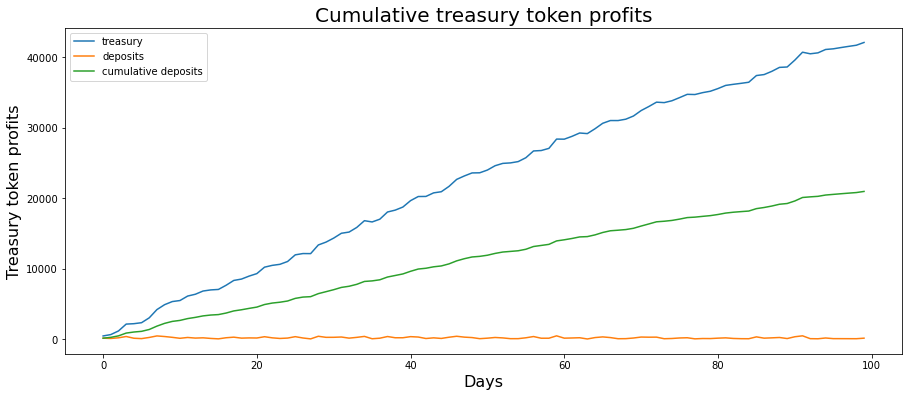

In [89]:
tSamp = list(range(N))
balances = [token.get_balance() for token in tTokenArr.get_array()]
deposits = [token.get_balance() for token in depositTokenArr.get_array()]
cum_deposits = list(np.cumsum(deposits))


fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(tSamp, balances, label='treasury') 
plt.plot(tSamp, deposits, label='deposits')
plt.plot(tSamp, cum_deposits, label='cumulative deposits')
plt.title("Cumulative treasury token profits", fontsize=20)
plt.ylabel("Treasury token profits", fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.legend()